In [1]:
from weaPoints import WeaPoints, WindDataType, CalculationMethod
import numpy as np
import xarray
import pandas

from global_setup import _CONN_PARAMS_DIC
from databaseLoad import read_postgres_from_queryfile
import plotly.express as px
import geopandas as gpd
import math

# Set Limit for displaying columns to None
pandas.set_option('max_columns', None)

# Path to sql query files
sql_path = "/home/eouser/Documents/code/Windatlas/windatlas/mastr/sqlQuerys/"
sql_data = "loadMastrWind.sql"

sql_data_path = sql_path + sql_data

In [2]:
bundesländer = {
    1400:"Brandenburg",
    1401:"Berlin",
    1402:"Baden-Würtenberg",
    1403:"Bayern",
    1404:"Bremen",
    1405:"Hessen",
    1406:"Hamburg",
    1407:"Mecklenburg-Vorpommern",
    1408:"Niedersachsen",
    1409:"Nordrhein-Westfahlen",
    1410:"Rheinland-Pfalz",
    1411:"Schleswig-Holstein",
    1412:"Saarland",
    1413:"Sachsen",
    1414:"Sachsen-Anhalt",
    1415:"Thüringen"}

In [3]:
dfMastrWind = read_postgres_from_queryfile(
        sql_query_path = sql_data_path,
        db_conn_data = _CONN_PARAMS_DIC
        )

dfMastrWind['SpezifischeLeistung'] = (dfMastrWind.Nettonennleistung * 1000) / (math.pi * (dfMastrWind.Rotordurchmesser / 2)**2)
dfMastrWind["Anlagenzahl"] = 1

dfMastrWind = dfMastrWind.replace({"Bundesland": bundesländer})
dfMastrWind

cond_modell = dfMastrWind["Typenbezeichnung"].str.contains("E48|E 48|E-48|e48|e 48|e-48", na=False)
cond_hersteller = dfMastrWind["Hersteller"] == 1586.0

dfrep = dfMastrWind.loc[cond_modell & cond_hersteller,:]
dfrep = dfrep[["EinheitMastrNummer","Inbetriebnahmedatum","Laengengrad","Breitengrad","Nabenhoehe","Bundesland"]].dropna(subset=["Laengengrad","Breitengrad","Nabenhoehe"])
dfrep["Typ"] = "Enercon_E-48"

In [4]:
dfrep = dfrep.head()

Passed time_frame valid.
TSnetCDF data loaded.
Time period loaded.
Windpower turbine 1 complete
Windpower turbine 2 complete
Windpower turbine 3 complete
Windpower turbine 4 complete
Windpower turbine 5 complete


<AxesSubplot:>

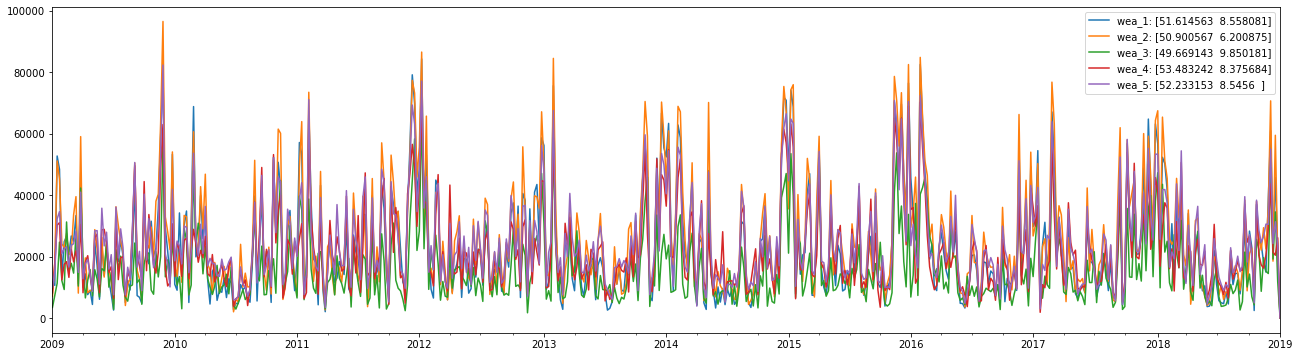

In [5]:
lat_lon_coor = np.stack((dfrep["Breitengrad"].values, dfrep["Laengengrad"].values), axis=1)

e48 = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = dfrep["Nabenhoehe"].values,
    wea_types = list(dfrep["Typ"].values),#["WEA_beispiel"] * lat_lon_coor.shape[0],
    #interpolation_method = [InterpolationMethod.LINEAR] * lat_lon_coor.shape[0],
    _interpolated_power_curves = True,
)

e48.get_windpower_out(wind_data_type=WindDataType.TSNETCDF, time_frame=[2009,"2018-12-31"])

Eout = {}
for num, point in enumerate(e48.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

dfe48 = pandas.DataFrame(data=Eout,index=e48.time_periode)
dfe48.iloc[:,:5].resample("1w").sum().plot(figsize=(22,6))

Passed time_frame valid.
TSnetCDF data loaded.
Time period loaded.
Windpower turbine 1 complete
Windpower turbine 2 complete
Windpower turbine 3 complete
Windpower turbine 4 complete
Windpower turbine 5 complete


<AxesSubplot:>

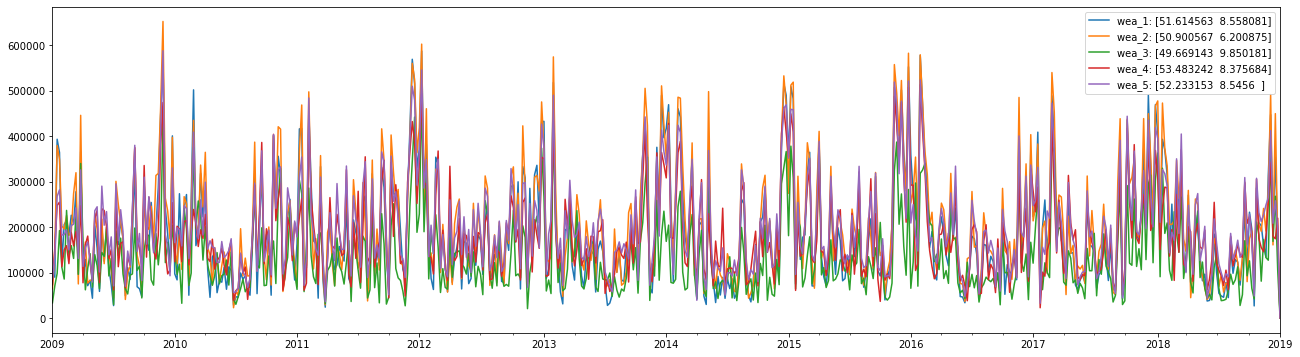

In [6]:
lat_lon_coor = np.stack((dfrep["Breitengrad"].values, dfrep["Laengengrad"].values), axis=1)

e147 = WeaPoints(
    lat_lon_coor = lat_lon_coor,
    level = dfrep["Nabenhoehe"].values,
    wea_types = ["Enercon_E-147"] * lat_lon_coor.shape[0],
    #interpolation_method = [InterpolationMethod.LINEAR] * lat_lon_coor.shape[0],
    _interpolated_power_curves = True,
)

e147.get_windpower_out(wind_data_type=WindDataType.TSNETCDF, time_frame=[2009,"2018-12-31"])

Eout = {}
for num, point in enumerate(e147.point_list):
    Eout[f"wea_{num+1}: {point.lat_lon_coor}"] = point.power_time_series

dfe147 = pandas.DataFrame(data=Eout,index=e147.time_periode)
dfe147.iloc[:,:5].resample("1w").sum().plot(figsize=(22,6))

## Difference in Power out

<AxesSubplot:>

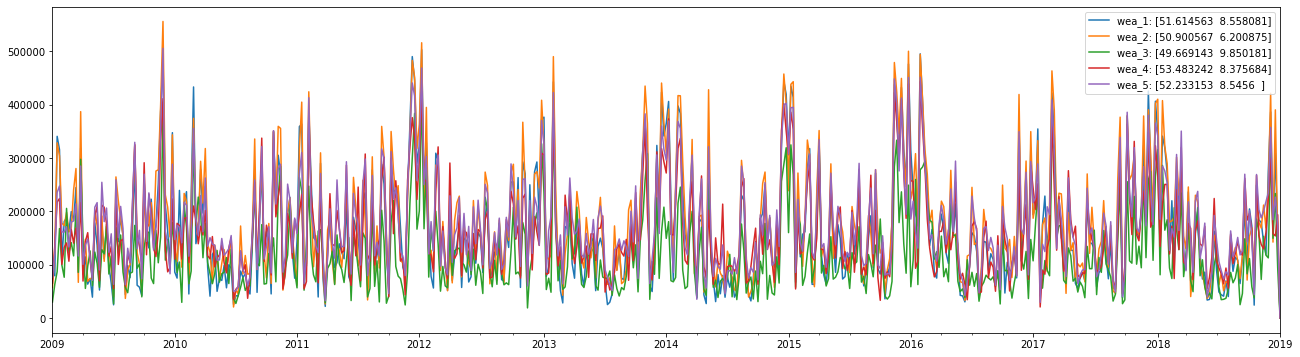

In [9]:
dfe147.subtract(dfe48).resample("1w").sum().plot(figsize=(22,6))